In [716]:
import pandas as pd
import numpy as np


In [717]:
df = pd.read_csv("resources/afad_10_25.csv")


In [718]:
# Change the column name eventDate to time
df.rename(columns={"eventDate": "time", "magnitude": "mag"}, inplace=True)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30311 entries, 0 to 30310
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   eventId        30311 non-null  int64  
 1   time           30311 non-null  object 
 2   longitude      30311 non-null  float64
 3   latitude       30311 non-null  float64
 4   depth          30311 non-null  float64
 5   magnitudeType  30311 non-null  object 
 6   mag            30311 non-null  float64
 7   area           30311 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.9+ MB
None


In [719]:
def clean_and_preprocess(df: pd.DataFrame):
    
    try:
        # Drop if data contains any non-eq rows
        df = df[df["type"] == "earthquake"]
    except:
        pass
    
    try:    
        # Drop high rms rows, uncertainty
        df = df[df["rms"] <= 1.7]
    except:
        pass
    
    columns = ["magSource", "locationSource", "status", "magNst", "magError", "depthError", "horizontalError", 
               "type", "updated", "id", "place", "net", "rms", "dmin", "gap", "magType", "nst"]
    
    # Drop non-informative columns
    for col in columns:
        try:
            df.drop(columns=[col], axis=1, inplace=True)
            print(f"Col {col} dropped successfully.")
        except Exception as e:
            print(f"Couldn't drop col {col}, {e}.")
    # These are mostly metadata related to measurements
    # They combine up to a location information, maybe useful but not necessary
    
    return df
    
    
# df = clean_and_preprocess(df)
try:
    df.drop(columns=["eventId", "magnitudeType", "area"], axis=1, inplace=True)
except Exception as e:
    print(f"Couldn't drop col, {e}.")
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30311 entries, 0 to 30310
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       30311 non-null  object 
 1   longitude  30311 non-null  float64
 2   latitude   30311 non-null  float64
 3   depth      30311 non-null  float64
 4   mag        30311 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.2+ MB


In [720]:
df["time"] = pd.to_datetime(df["time"])


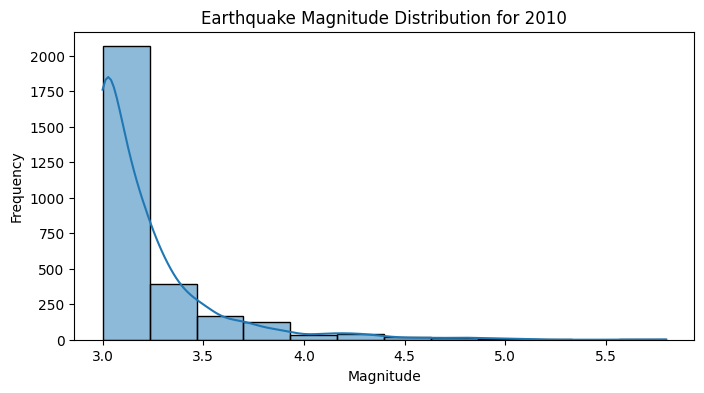

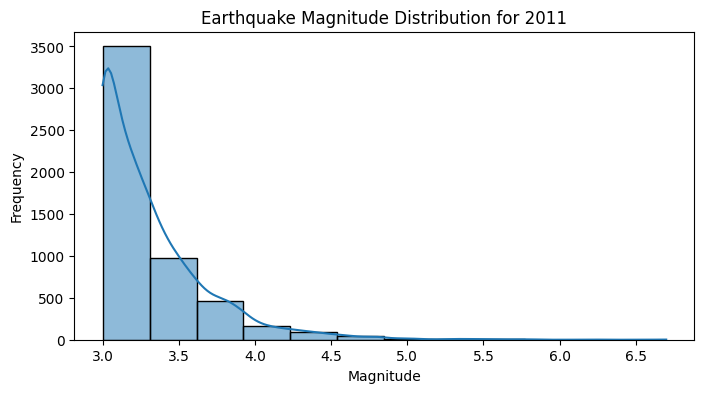

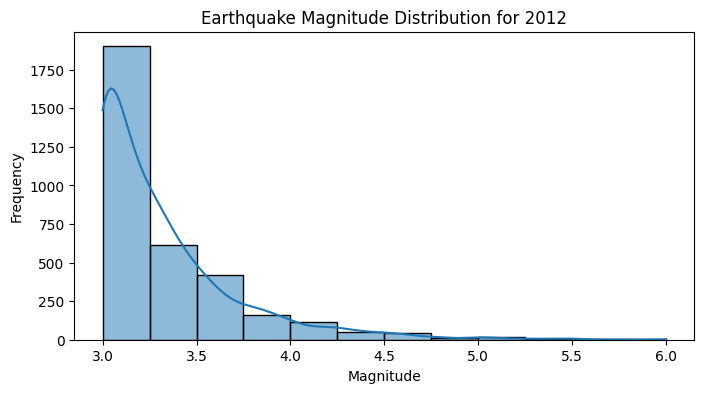

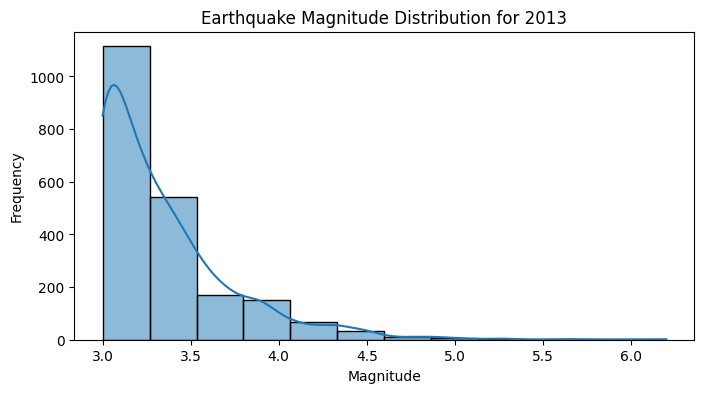

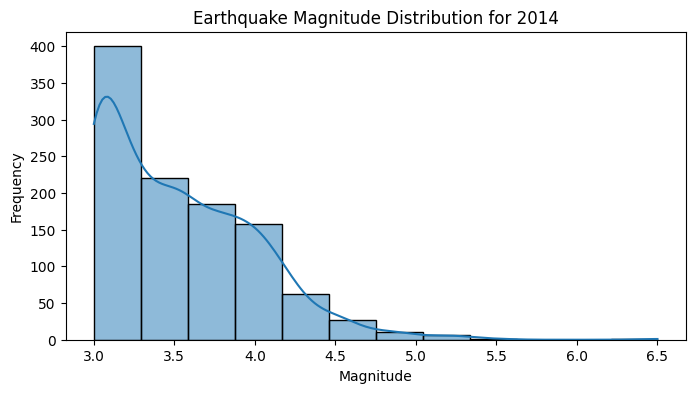

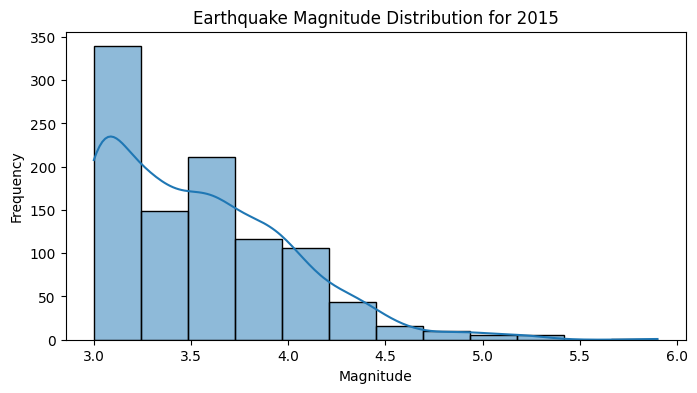

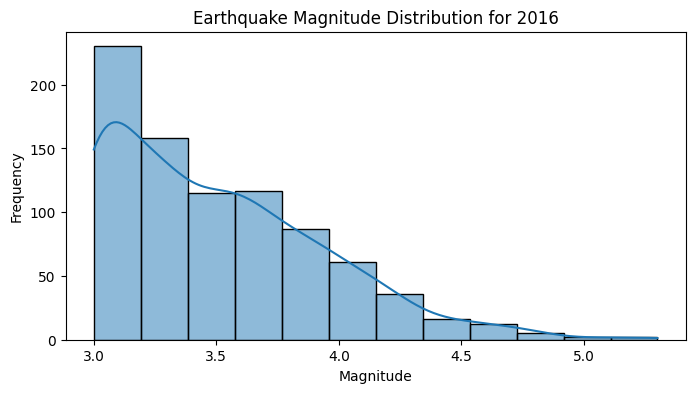

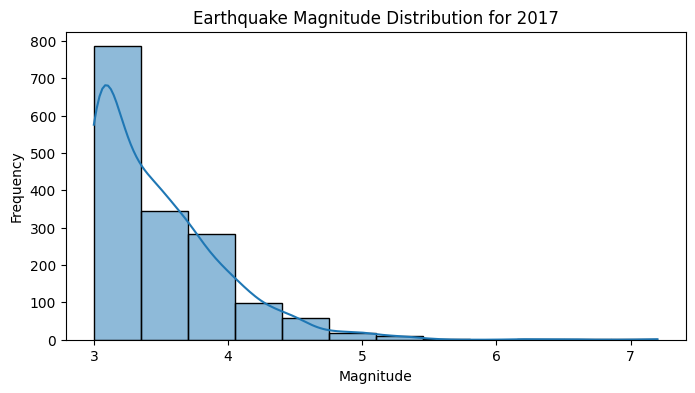

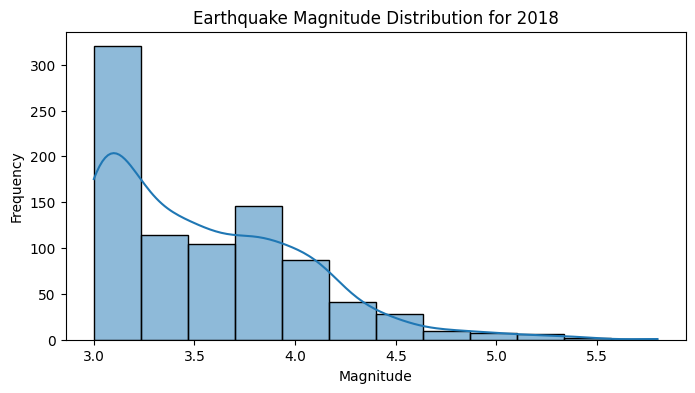

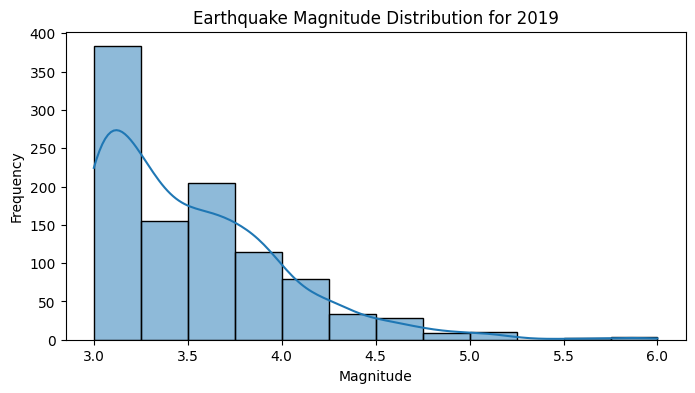

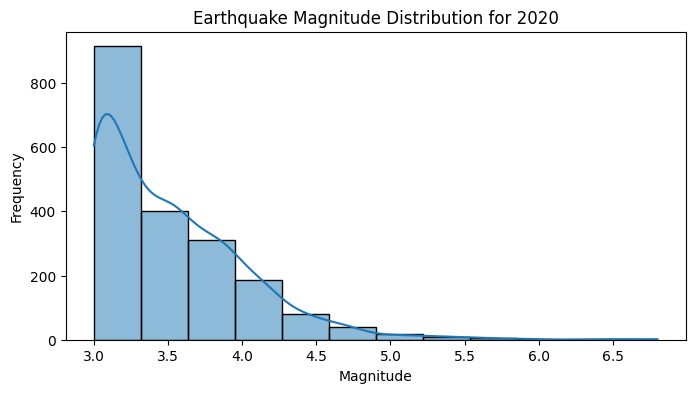

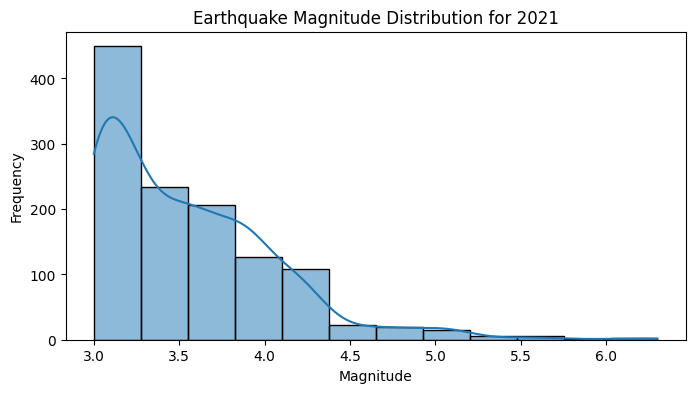

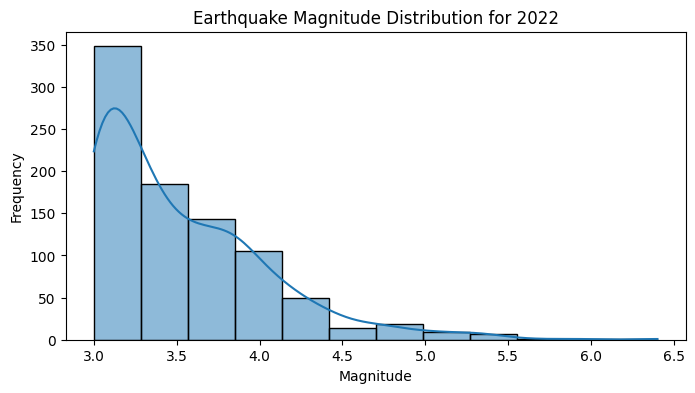

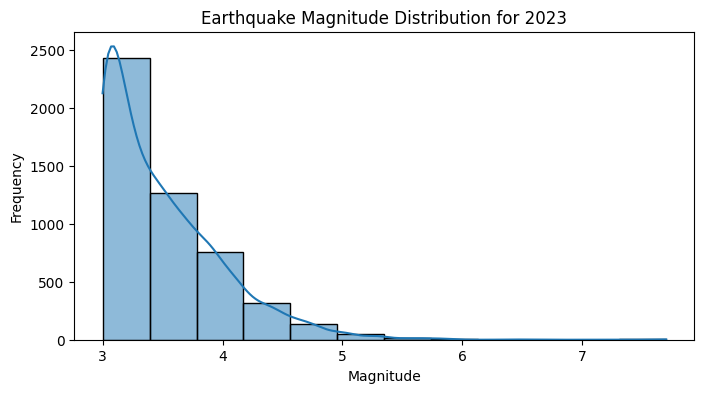

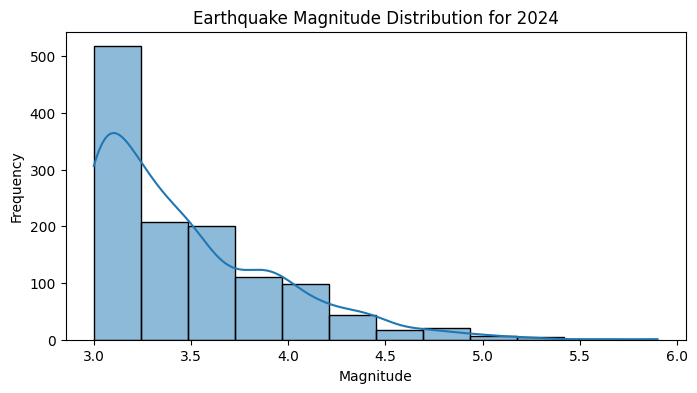

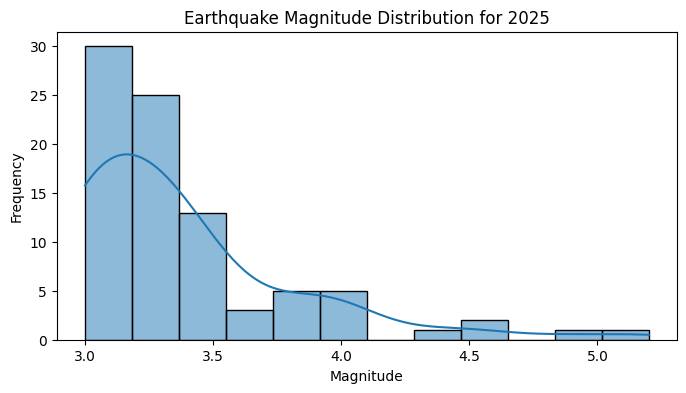

In [721]:
import matplotlib.pyplot as plt
import seaborn as sns

df_copy = df.copy()

# Plot the magnitude distribution for each year from 1990 to 2025
df_copy["year"] = df["time"].dt.year
def plot_mag_dist(df: pd.DataFrame):
    for year in range(2010, 2026):
        plt.figure(figsize=(8, 4))
        sns.histplot(df[df["year"] == year]["mag"], bins=12, kde=True)
        plt.title(f"Earthquake Magnitude Distribution for {year}")
        plt.xlabel("Magnitude")
        plt.ylabel("Frequency")
        plt.show()
 
plot_mag_dist(df_copy)


In [722]:
df_copy = df.copy()

# Order by the time descending
df_copy = df_copy.sort_values(by="time", ascending=False)
latest_earthquakes = df_copy.head(600)

print(latest_earthquakes)

                   time  longitude  latitude  depth  mag
0   2025-01-30 04:36:21   23.55750  36.27250   7.01  3.3
1   2025-01-30 04:24:03   26.19056  36.25111  40.28  3.2
2   2025-01-30 01:37:44   27.10528  36.66722  36.47  3.3
3   2025-01-29 22:54:26   45.35611  34.65583  24.90  3.7
4   2025-01-29 01:44:52   37.88556  38.11778  15.28  3.5
..                  ...        ...       ...    ...  ...
595 2024-07-25 15:50:31   27.02333  37.77111   7.01  3.5
596 2024-07-25 11:17:05   39.47000  39.90222   6.97  3.1
597 2024-07-25 02:34:24   31.12528  37.29139   5.58  3.4
598 2024-07-24 20:20:13   36.04444  40.04889   7.00  4.0
599 2024-07-24 07:14:09   30.36694  35.85528  35.80  3.3

[600 rows x 5 columns]


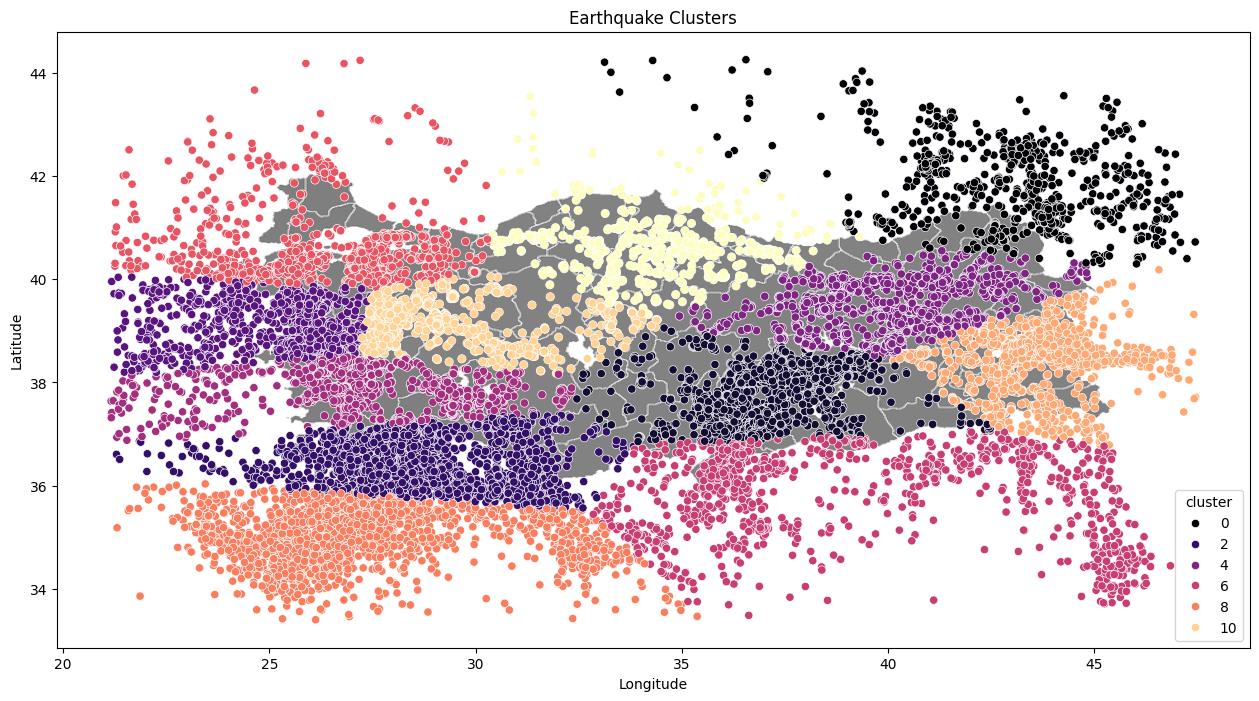

Cluster 0 mean latitude: 41.78840438730853, mean longitude: 42.93830636761488
Cluster 1 mean latitude: 37.87410353206574, mean longitude: 37.372301090879795
Cluster 2 mean latitude: 36.5376528248114, mean longitude: 28.51634664151998
Cluster 3 mean latitude: 39.17690780028944, mean longitude: 25.654118094548963
Cluster 4 mean latitude: 39.34669173262548, mean longitude: 39.96179359073359
Cluster 5 mean latitude: 37.853414536440255, mean longitude: 27.31171627169063
Cluster 6 mean latitude: 35.96827045698925, mean longitude: 38.311577264784944
Cluster 7 mean latitude: 40.59062909841707, mean longitude: 26.57358715760495
Cluster 8 mean latitude: 35.044478375808296, mean longitude: 27.164181780144542
Cluster 9 mean latitude: 38.614407224816546, mean longitude: 43.43761937069157
Cluster 10 mean latitude: 39.11440847288676, mean longitude: 28.99563458133971
Cluster 11 mean latitude: 40.62560198857143, mean longitude: 34.17953704


In [723]:
df_copy = df.copy()

num_clusters = 12

# Order by the time descending
df_copy = df_copy.sort_values(by="time", ascending=False)
latest_earthquakes = df_copy

# Use KNN to cluster the earthquakes based on their coordinates
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# We will use the latitude and longitude columns
X = latest_earthquakes[["latitude", "longitude"]]
scaler = StandardScaler()
X = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
latest_earthquakes["cluster"] = kmeans.fit_predict(X)

# Plot the clusters
fig, ax = plt.subplots(figsize=(16, 8))

# Read and display the map
img = plt.imread("resources/turkey_map.png")

# Define the geographical boundaries of Turkey
# Adjusted extent to stretch horizontally and compress vertically
extent = [24, 45.5, 35.5, 42.5]  # Shifted slightly west and adjusted latitude range

# Display the map with correct extent and aspect
ax.imshow(img, extent=extent, aspect=1.25, cmap="gray")  # Increased aspect ratio for horizontal stretch

sns.scatterplot(data=latest_earthquakes, x="longitude", y="latitude", hue="cluster", palette="magma")

plt.title("Earthquake Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

cluster_mean_lat = []
cluster_mean_lon = []

for i in range(num_clusters):
    cluster_mean_lat.append(latest_earthquakes[latest_earthquakes["cluster"] == i]["latitude"].mean())
    cluster_mean_lon.append(latest_earthquakes[latest_earthquakes["cluster"] == i]["longitude"].mean())

for i in range(num_clusters):
    print(f"Cluster {i} mean latitude: {cluster_mean_lat[i]}, mean longitude: {cluster_mean_lon[i]}")

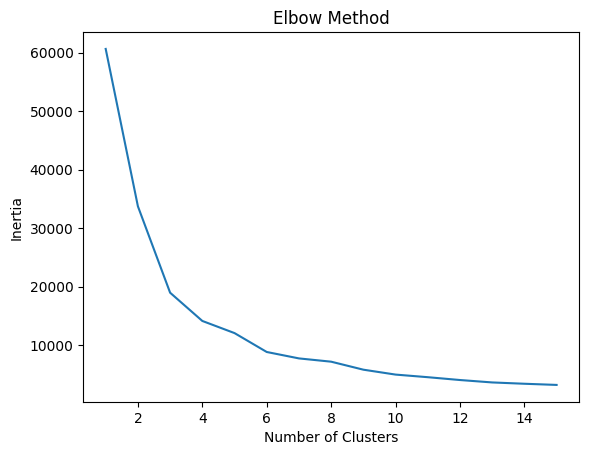

In [724]:
df_copy = df.copy()

# Find the ideal number of clusters for KMeans, using Elbow Method
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df_copy[["latitude", "longitude"]]
scaler = StandardScaler()
X = scaler.fit_transform(X)

inertia = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(1, 16), inertia)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [725]:
def find_cluster(lat: float, lon: float, clusters_mean_lat: list, clusters_mean_lon: list):    
    min_dist = 1000000
    cluster = -1
    for i in range(num_clusters):
        dist = np.sqrt((lat - clusters_mean_lat[i])**2 + (lon - clusters_mean_lon[i])**2)
        if dist < min_dist:
            min_dist = dist
            cluster = i
    return cluster


In [726]:
df_copy = df.copy()

recent_eq_data = df_copy.sort_values(by="time", ascending=False)


In [727]:
recent_eq_data["cluster"] = recent_eq_data.apply(lambda x: find_cluster(x["latitude"], x["longitude"], cluster_mean_lat, cluster_mean_lon), axis=1)

In [728]:
print(recent_eq_data["cluster"].value_counts())

cluster
1     6608
9     4997
2     3091
10    2744
8     2585
3     2449
5     2375
4     2125
11    1002
7      907
0      884
6      544
Name: count, dtype: int64


In [729]:
# Convert the time column to date only format
print(recent_eq_data["time"])
recent_eq_data["time"] = pd.to_datetime(recent_eq_data["time"], format="%Y-%m-%d")

0       2025-01-30 04:36:21
1       2025-01-30 04:24:03
2       2025-01-30 01:37:44
3       2025-01-29 22:54:26
4       2025-01-29 01:44:52
                ...        
30306   2010-01-01 11:03:11
30307   2010-01-01 07:33:28
30308   2010-01-01 05:37:55
30309   2010-01-01 01:28:03
30310   2009-12-31 22:05:01
Name: time, Length: 30311, dtype: datetime64[ns]


In [730]:
clustered_dfs = []
for i in range(num_clusters):
    clustered_dfs.append(recent_eq_data[recent_eq_data["cluster"] == i])
    

In [731]:
import datetime

partitioned_dfs = []
for i in range(len(clustered_dfs)):
    partitioned_dfs.append(pd.DataFrame())

# Iterate over each cluster, partition the data into 2 week periods.
for i in range(len(clustered_dfs)):
    cluster_df = clustered_dfs[i]
    
    starting_date = cluster_df["time"].min()
    final_date = cluster_df["time"].max() # Final date of the data
    period_end = final_date.date()
    period_start = period_end - datetime.timedelta(days=7)
    
    current_partitioned_df = partitioned_dfs[i]
    # Initialize the interval column, to store the 2 week periods
    current_partitioned_df["interval"] = None
    
    # Iterate over the 2 week periods, until the
    while datetime.datetime.combine(period_start, datetime.datetime.min.time()) >= starting_date:
        
        # Filter the data for the current period
        period_start_dt = datetime.datetime.combine(period_start, datetime.datetime.min.time())
        period_end_dt = datetime.datetime.combine(period_end, datetime.datetime.min.time())
        
        # Filter the data for the current period
        period_df = cluster_df[(cluster_df["time"] >= period_start_dt) & (cluster_df["time"] < period_end_dt)]
        
        # Create an entry in the current partitioned df with the interval and set a target variable
        # 1 if there is an earthquake greater than 5.0
        
        # Check if there's any earthquake with magnitude > 5.0 in this period
        significant_earthquake = int(any(period_df["mag"] > 5.0))
        max_magnitude = period_df["mag"].max() if len(period_df) > 0 else 0
        
        # Create new row for the current period
        new_row = pd.DataFrame({
            'interval': [f"{period_start} / {period_end}"],
            'target': [significant_earthquake],
        })
        
        # Append the new row to the current partitioned df
        current_partitioned_df = pd.concat([current_partitioned_df, new_row], ignore_index=True)
        
        # Add features from the prior 30 days of the interval
        prior_30_days = datetime.datetime.combine(period_start - datetime.timedelta(days=30), datetime.datetime.min.time())
        prior_30_days_df = cluster_df[(cluster_df["time"] >= prior_30_days) & (cluster_df["time"] < period_start_dt)]
        
        # Add the number of earthquakes in the prior 30 days
        num_earthquakes = len(prior_30_days_df)
        current_partitioned_df.loc[current_partitioned_df["interval"] == f"{period_start} / {period_end}", "num_earthquakes"] = num_earthquakes
        
        # Add the maximum magnitude in the prior 30 days
        current_partitioned_df.loc[current_partitioned_df["interval"] == f"{period_start} / {period_end}", "max_magnitude"] = prior_30_days_df["mag"].max() if len(prior_30_days_df) > 0 else 0
        
        # Add the average magnitude in the prior 30 days
        avg_magnitude = prior_30_days_df["mag"].mean() if len(prior_30_days_df) > 0 else 0
        current_partitioned_df.loc[current_partitioned_df["interval"] == f"{period_start} / {period_end}", "avg_magnitude"] = avg_magnitude
        
        # Add the all time maximum magnitude, up to the current period
        all_time_max_magnitude = cluster_df[cluster_df["time"] < period_end_dt]["mag"].max()
        current_partitioned_df.loc[current_partitioned_df["interval"] == f"{period_start} / {period_end}", "all_time_max_magnitude"] = all_time_max_magnitude
        
        period_end = period_start
        period_start = period_start - datetime.timedelta(days=7)
    
    # Move the target column to the end
    current_partitioned_df = current_partitioned_df[["interval", "num_earthquakes", "max_magnitude", "avg_magnitude", "all_time_max_magnitude", "target"]]
    
    partitioned_dfs[i] = current_partitioned_df
    

In [732]:
# Collect the partitioned dataframes into a single dataframe, with a cluster column
final_df = pd.DataFrame()

for i in range(len(partitioned_dfs)):
    partitioned_dfs[i]["cluster"] = i
    final_df = pd.concat([final_df, partitioned_dfs[i]], ignore_index=True)
    

In [733]:
print(final_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   interval                9424 non-null   object 
 1   num_earthquakes         9424 non-null   float64
 2   max_magnitude           9424 non-null   float64
 3   avg_magnitude           9424 non-null   float64
 4   all_time_max_magnitude  9424 non-null   float64
 5   target                  9424 non-null   float64
 6   cluster                 9424 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 515.5+ KB
None


In [734]:
# Order the dataframe by the interval column
final_df["interval"] = pd.to_datetime(final_df["interval"].str.split(" / ").str[0])
final_df = final_df.sort_values(by="interval", ascending=True)


In [735]:
print(final_df)


       interval  num_earthquakes  max_magnitude  avg_magnitude  \
2354 2010-01-02              2.0            3.3       3.200000   
9423 2010-01-03              1.0            3.0       3.000000   
8637 2010-01-04              2.0            3.2       3.100000   
3926 2010-01-04              2.0            3.3       3.150000   
5497 2010-01-04              4.0            3.3       3.150000   
...         ...              ...            ...            ...   
7066 2025-01-22              8.0            4.3       3.325000   
783  2025-01-22             20.0            4.4       3.405000   
6280 2025-01-23              7.0            4.5       3.500000   
3927 2025-01-23              2.0            3.5       3.300000   
2355 2025-01-23              6.0            5.2       3.566667   

      all_time_max_magnitude  target  cluster  
2354                     3.9     0.0        2  
9423                     3.3     0.0       11  
8637                     3.5     0.0       10  
3926           

In [736]:
test_data = final_df[final_df["interval"] >= "2018-01-01"]
train_data = final_df[final_df["interval"] < "2018-01-01"]

# Order the data by the interval column
train_data = train_data.sort_values(by="interval", ascending=True)
test_data = test_data.sort_values(by="interval", ascending=True)

print(train_data.shape, test_data.shape)

(5006, 7) (4418, 7)


In [737]:
print(train_data)
print("----"*20)
print(test_data)

       interval  num_earthquakes  max_magnitude  avg_magnitude  \
2354 2010-01-02              2.0            3.3       3.200000   
9423 2010-01-03              1.0            3.0       3.000000   
8637 2010-01-04              2.0            3.2       3.100000   
3926 2010-01-04              2.0            3.3       3.150000   
5497 2010-01-04              4.0            3.3       3.150000   
...         ...              ...            ...            ...   
6649 2017-12-28              9.0            4.7       3.922222   
1937 2017-12-30              9.0            4.5       3.544444   
5863 2017-12-31              2.0            3.5       3.250000   
9006 2017-12-31              2.0            3.4       3.200000   
366  2017-12-31              0.0            0.0       0.000000   

      all_time_max_magnitude  target  cluster  
2354                     3.9     0.0        2  
9423                     3.3     0.0       11  
8637                     3.5     0.0       10  
3926           

In [738]:
# Encode the interval column, as year, month, day
train_data["year"] = train_data["interval"].dt.year
train_data["month"] = train_data["interval"].dt.month
train_data["day"] = train_data["interval"].dt.day

test_data["year"] = test_data["interval"].dt.year
test_data["month"] = test_data["interval"].dt.month
test_data["day"] = test_data["interval"].dt.day

In [742]:
# Build a random forest classifier to predict the target variable
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

# Define the features and target variable
features = ["num_earthquakes", "max_magnitude", "avg_magnitude", "all_time_max_magnitude", "year", "month", "day", "cluster"]
target = "target"

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

# Use encoder to encode the cluster column
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

X_train_encoded = encoder.fit_transform(X_train["cluster"].values.reshape(-1, 1)).toarray()
X_test_encoded = encoder.transform(X_test["cluster"].values.reshape(-1, 1)).toarray()

# Scale the numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.drop(columns=["cluster"]))
X_test = scaler.transform(X_test.drop(columns=["cluster"]))

X_train = np.concatenate([X_train, X_train_encoded], axis=1)
X_test = np.concatenate([X_test, X_test_encoded], axis=1)

# Train the model
clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
clf.fit(X_train, y_train)

# Evaluate the model
train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

test_acc = accuracy_score(y_test, test_preds)

test_f1 = f1_score(y_test, test_preds)
print(f"Test F1 Score: {test_f1}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix

test_conf_matrix = confusion_matrix(y_test, test_preds)

print(f"Test Confusion Matrix: \n{test_conf_matrix}")


Test F1 Score: 0.06060606060606061
Test Confusion Matrix: 
[[4322    3]
 [  90    3]]


In [740]:
feature_names = features + [f'cluster_{i}' for i in range(X_train_encoded.shape[1])]
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

for i, row in importances.iterrows():
    print(f"{row['feature']}: {row['importance']}")

num_earthquakes: 0.22048673219446416
avg_magnitude: 0.20562883699850434
max_magnitude: 0.177542455074774
day: 0.1122032000232363
all_time_max_magnitude: 0.07991659410936539
month: 0.0688382648896904
year: 0.060675131058780904
cluster: 0.025416071651988798
cluster_8: 0.010063780314760707
cluster_3: 0.006834276185166717
cluster_2: 0.006649239987769692
cluster_5: 0.005102276294948907
cluster_7: 0.0048096504902438685
cluster_9: 0.0039064712829177
cluster_1: 0.0034049980420504627
cluster_4: 0.0027508420436316073
cluster_10: 0.0024944083668653107
cluster_0: 0.002091588326583934
cluster_6: 0.0006450414056561787
cluster_11: 0.0005401412586006763
